# Dev-Jor

Dataset: MS COCO (lest your GPU has constraints then use Flickr8k/30k let us know)

Evaluation: BLEU, METEOR, and CIDEr
1. Pretrained CNN + Untrained RNN 

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO
import nltk
import time
import tqdm
from tempfile import TemporaryDirectory
import numpy as np
import matplotlib.pyplot as plt
import random
# from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
# from nltk.translate.meteor_score import meteor_score
# from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider

In [2]:
# Set random seeds for reproducibility
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class CocoDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None, max_length=50):
        """
        Args:
            root_dir (string): Directory with all the images
            ann_file (string): Path to annotation file
            transform: Optional transform to be applied on images
            max_length (int): Maximum length of captions (with padding)
        """
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.anns.keys())
        self.max_length = max_length

        # Build vocabulary
        self.word_freq = Counter()
        self.build_vocabulary()

        # Create word mappings
        words = [word for word, count in self.word_freq.items() if count >= 5]
        self.word2idx = {word: idx + 1 for idx, word in enumerate(words)}
        self.word2idx['<pad>'] = 0
        self.word2idx['<start>'] = len(self.word2idx)
        self.word2idx['<end>'] = len(self.word2idx)
        self.word2idx['<unk>'] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)

    def build_vocabulary(self):
        """Build a simple vocabulary wrapper."""
        nltk.download('punkt')
        nltk.download('punkt_tab')

        for i, id in enumerate(self.ids):
            caption = self.coco.anns[id]['caption']
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            self.word_freq.update(tokens)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root_dir, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption to tensor
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(self.word2idx['<start>'])
        caption.extend([self.word2idx.get(token, self.word2idx['<unk>']) for token in tokens])
        caption.append(self.word2idx['<end>'])

        # Pad the caption to max_length
        if len(caption) > self.max_length:
            caption = caption[:self.max_length]
        else:
            caption.extend([self.word2idx['<pad>']] * (self.max_length - len(caption)))

        return image, torch.tensor(caption), img_id

def get_data_loader(root_dir, ann_file, transform, batch_size=32, shuffle=True, num_workers=0):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    dataset = CocoDataset(root_dir=root_dir,
                         ann_file=ann_file,
                         transform=transform)

    data_loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=num_workers,
                            pin_memory=torch.cuda.is_available(),  # Use pin_memory if using GPU
                            persistent_workers=True if num_workers > 0 else False  # Keep workers alive between iterations
                            )
    return data_loader, dataset

# In your training script, modify the transforms:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Larger size for random cropping
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [ ]:
# Define base paths
BASE_PATH = '/data'
IMG_DIR = os.path.join(BASE_PATH, 'images')
ANN_DIR = os.path.join(BASE_PATH, 'annotations/trainval2017')

In [ ]:
# Create data loaders
train_loader, train_dataset = get_data_loader(
    root_dir=os.path.join(IMG_DIR, 'train2017'),
    ann_file=os.path.join(ANN_DIR, 'captions_train2017.json'),
    transform=transform,
    batch_size=128,
    shuffle=True
)

val_loader, val_dataset = get_data_loader(
    root_dir=os.path.join(IMG_DIR, 'val2017'),
    ann_file=os.path.join(ANN_DIR, 'captions_val2017.json'),
    transform=transform,
    batch_size=128,
    shuffle=False
)

In [ ]:
print(f"Vocabulary size: {train_dataset.vocab_size}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

In [ ]:
# Save vocabulary for later use
vocab_path = os.path.join(BASE_PATH, 'vocab.json')
vocab_info = {
    'word2idx': train_dataset.word2idx,
    'idx2word': {str(k): v for k, v in train_dataset.idx2word.items()},  # Convert int keys to str for JSON
    'vocab_size': train_dataset.vocab_size
}
with open(vocab_path, 'w') as f:
    json.dump(vocab_info, f)
print(f"Vocabulary saved to {vocab_path}")

In [ ]:
# Test the dataloader
print("\nTesting dataloader...")
print(f"Number of samples in dataset: {len(train_dataset)}")

# Test a single sample directly from the dataset
print("\nTesting single sample from dataset...")
image, caption, img_id = train_dataset[0]  # Get the first sample
print(f"Image ID: {img_id}")
print(f"Single image shape: {image.shape}")
print(f"Single caption shape: {caption.shape}")

# Convert caption to readable text
caption_words = [train_dataset.idx2word[idx.item()] for idx in caption]
caption_text = ' '.join(word for word in caption_words
                      if word not in ['<pad>', '<start>', '<end>'])
print(f"Sample caption: {caption_text}")

# Test a single batch using iter
print("Length of train loader:", len(train_loader))
print("Dataset length:", len(train_loader.dataset))
images, captions, _ = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")
print(f"Batch caption shape: {captions.shape}")

print(f"\nVocabulary size: {train_dataset.vocab_size}")

In [ ]:
def display_image_with_captions(dataset, img_id=None, coco_caps=None):
    """
    Display an image with its captions using the CocoDataset.

    Args:
        dataset: CocoDataset instance
        img_id: Optional specific image ID to display
        coco_caps: Optional COCO caption annotations object
    """
    import matplotlib.pyplot as plt
    import torch

    if coco_caps is None:
        coco_caps = dataset.coco

    if img_id is None:
        # Get random annotation ID
        ann_ids = coco_caps.getAnnIds()
        random_ann = random.choice(ann_ids)
        img_id = coco_caps.loadAnns(random_ann)[0]['image_id']
        print(f"Randomly selected image ID: {img_id}")

    # Load image info
    img_info = coco_caps.loadImgs([img_id])[0]

    # Load image using PIL
    img_path = os.path.join(dataset.root_dir, img_info['file_name'])
    image = Image.open(img_path).convert('RGB')

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Display image
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Image id: ' + str(img_id))

    # Get and display captions
    ann_ids = coco_caps.getAnnIds(imgIds=img_id)
    anns = coco_caps.loadAnns(ann_ids)

    # Create text display for captions
    caption_text = '\n\n'.join([f"Caption {i+1} (ID: {ann['id']}): {ann['caption']}"
                               for i, ann in enumerate(anns)])
    ax2.text(0.1, 0.5, caption_text,
             wrap=True,
             verticalalignment='center',
             fontsize=10)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return img_id, anns

def display_dataset_samples(dataset, num_samples=3):
    """
    Display multiple random samples from the dataset with their captions.

    Args:
        dataset: CocoDataset instance
        num_samples: Number of samples to display
    """
    print(f"Displaying {num_samples} random samples from the dataset...")

    for i in range(num_samples):
        print(f"\nSample {i+1}:")
        print("-" * 80)

        # Get a random sample
        idx = random.randint(0, len(dataset)-1)
        image, caption_tensor, img_id = dataset[idx]

        # Convert image tensor back to PIL Image for display
        # Denormalize the image
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        image_denorm = image * std + mean
        image_denorm = image_denorm.clip(0, 1)

        # Convert caption indices to words
        caption_words = [dataset.idx2word[idx.item()] for idx in caption_tensor]
        caption_text = ' '.join(word for word in caption_words
                              if word not in ['<pad>', '<start>', '<end>'])

        # Display
        plt.figure(figsize=(8, 6))
        plt.imshow(image_denorm.permute(1, 2, 0))
        plt.axis('off')
        plt.title("Image")
        plt.show()

        print("\nProcessed Caption:")
        print(caption_text)
        print("-" * 80)

In [ ]:
# Example usage:
# Display a specific image with its raw captions
display_image_with_captions(val_dataset, img_id=502732)
display_image_with_captions(val_dataset, img_id=78565)
display_image_with_captions(val_dataset, img_id=255165)
print()

# Display random images with processed captions from the dataset
# display_dataset_samples(train_dataset, num_samples=3)

In [ ]:
# Cell 3: Define the model architecture
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

# Modified DecoderRNN with improved architecture
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2, max_seq_length=50):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, 
                           batch_first=True, bidirectional=True,
                           dropout=0.5 if num_layers > 1 else 0)
        self.linear = nn.Linear(hidden_size * 2, vocab_size)  # *2 for bidirectional
        self.init_h = nn.Linear(embed_size, hidden_size)  
        self.init_c = nn.Linear(embed_size, hidden_size)
        self.dropout = nn.Dropout(0.7)
        self.max_seq_length = max_seq_length

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = self.dropout(embeddings)
        
        # Initialize hidden states
        batch_size = features.size(0)
        h_init = self.init_h(features)  # [batch_size, hidden_size]
        c_init = self.init_c(features)  # [batch_size, hidden_size]
        
        # Reshape for bidirectional LSTM
        # [num_layers * num_directions, batch_size, hidden_size]
        h = torch.stack([h_init] * self.num_layers * 2)  
        c = torch.stack([c_init] * self.num_layers * 2)
        
        # Forward propagate LSTM
        hiddens, _ = self.lstm(embeddings, (h, c))
        outputs = self.linear(hiddens)
        return outputs

    def sample(self, features, word2idx, max_len=20):
        """Generate captions using greedy decoding."""
        self.eval()
        batch_size = features.size(0)
        
        # Initialize hidden states
        h_init = self.init_h(features)  # [batch_size, hidden_size]
        c_init = self.init_c(features)  # [batch_size, hidden_size]
        
        # Reshape for bidirectional LSTM
        h = torch.stack([h_init] * self.num_layers * 2)
        c = torch.stack([c_init] * self.num_layers * 2)
        
        inputs = torch.tensor([word2idx['<start>']] * batch_size).unsqueeze(1).to(features.device)
        sampled_ids = []
        
        for i in range(max_len):
            embeddings = self.embed(inputs)
            embeddings = self.dropout(embeddings)
            lstm_out, (h, c) = self.lstm(embeddings, (h, c))
            outputs = self.linear(lstm_out.squeeze(1))
            predicted = outputs.argmax(dim=1)
            sampled_ids.append(predicted)
            
            inputs = predicted.unsqueeze(1)
            
            if all(pred.item() == word2idx['<end>'] for pred in predicted):
                break
        
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids

class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, max_seq_length=50):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, max_seq_length)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, word2idx, idx2word, max_len=20):
        """Generate caption for a single image."""
        self.eval()
        with torch.no_grad():
            features = self.encoder(image.unsqueeze(0))
            sampled_ids = self.decoder.sample(features, word2idx, max_len)
            sampled_ids = sampled_ids[0].cpu().numpy()

        # Convert word ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = idx2word[str(word_id)]  # Convert id to string for JSON lookup
            if word == '<end>':
                break
            if word not in ['<start>', '<pad>']:
                sampled_caption.append(word)

        return ' '.join(sampled_caption)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=True):
        """
        Args:
            patience (int): How many epochs to wait before stopping when loss is no longer improving
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement
            verbose (bool): If True, prints a message for each validation loss improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.min_val_loss:
                self.min_val_loss = val_loss
            self.best_loss = val_loss
            self.counter = 0

In [ ]:
# Modified training setup
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=30, device='cuda', patience=5, gradient_accumulation_steps=4):
    """
    Train the model with improved regularization and learning rate scheduling
    """
    # Create checkpoint directory in Google Drive
    save_dir = '/content/drive/MyDrive/data/checkpoints'
    os.makedirs(save_dir, exist_ok=True)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True,
        min_lr=1e-6
    )

    # Initialize training tracking
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    # Path for best model
    best_model_path = os.path.join(save_dir, 'best_model.pt')

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        model.train()
        total_train_loss = 0
        train_steps = 0
        optimizer.zero_grad()  # Zero gradients at start of epoch

        train_progress_bar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
        for i, (images, captions, _) in enumerate(train_progress_bar):
            images = images.to(device)
            captions = captions.to(device)

            inputs = captions[:, :-1]
            targets = captions[:, 1:]

            outputs = model(images, inputs)
            batch_size, seq_length, vocab_size = outputs.shape
            outputs = outputs.reshape(-1, vocab_size)
            targets = targets.reshape(-1)

            # Calculate loss and scale it
            loss = criterion(outputs, targets) / gradient_accumulation_steps
            loss.backward()

            # Update weights every gradient_accumulation_steps or at the end of epoch
            if (i + 1) % gradient_accumulation_steps == 0 or (i + 1) == len(train_loader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            total_train_loss += loss.item() * gradient_accumulation_steps
            train_steps += 1
            train_progress_bar.set_postfix({'train_loss': total_train_loss/train_steps})

        avg_train_loss = total_train_loss / train_steps
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_steps = 0

        val_progress_bar = tqdm.tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
        with torch.no_grad():
            for i, (images, captions, _) in enumerate(val_progress_bar):
                images = images.to(device)
                captions = captions.to(device)

                inputs = captions[:, :-1]
                targets = captions[:, 1:]

                outputs = model(images, inputs)
                batch_size, seq_length, vocab_size = outputs.shape
                outputs = outputs.reshape(-1, vocab_size)
                targets = targets.reshape(-1)

                loss = criterion(outputs, targets)
                total_val_loss += loss.item()
                val_steps += 1

                val_progress_bar.set_postfix({'val_loss': total_val_loss/val_steps})

        avg_val_loss = total_val_loss / val_steps
        val_losses.append(avg_val_loss)

        # Update learning rate scheduler
        scheduler.step(avg_val_loss)

        # Early stopping check
        early_stopping(avg_val_loss)

        # Save checkpoint every epoch
        checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),  # Save scheduler state
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
        }, checkpoint_path)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_losses': train_losses,
                'val_losses': val_losses,
            }, best_model_path)
            print(f"New best model saved to {best_model_path}")

        # Print epoch statistics
        epoch_time = time.time() - start_time
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Time: {epoch_time:.2f}s')
        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 60)

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model, train_losses, val_losses

In [ ]:
# Model hyperparameters
embed_size = 256
hidden_size = 256  # Changed from 512 to match dimensions
num_layers = 2
learning_rate = 0.001

# Model initialization with improved parameters
model = ImageCaptioningModel(
    embed_size=embed_size,
    hidden_size=hidden_size,
    vocab_size=len(train_dataset.word2idx),
    num_layers=num_layers  # Increased number of layers
).to(device)

# Loss and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.word2idx['<pad>'])
params = list(model.decoder.parameters()) + list(model.encoder.linear.parameters()) + list(model.encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=1e-4)  # Added weight decay

# Train the model
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=30,
    device=device,
    patience=5,
    gradient_accumulation_steps=4
)

In [ ]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing

In [4]:
# Make sure we have the tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jordan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Jordan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
# Cell 2: Define the Dataset class
class CocoDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None, max_length=50):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.anns.keys())
        self.max_length = max_length
        
        # Load vocabulary from saved file
        vocab_path = os.path.join('data', 'vocab.json')
        with open(vocab_path, 'r') as f:
            vocab_info = json.load(f)
            self.word2idx = vocab_info['word2idx']
            self.idx2word = vocab_info['idx2word']
            self.vocab_size = vocab_info['vocab_size']

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root_dir, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption to tensor
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(self.word2idx['<start>'])
        caption.extend([self.word2idx.get(token, self.word2idx['<unk>']) for token in tokens])
        caption.append(self.word2idx['<end>'])

        # Pad the caption
        if len(caption) > self.max_length:
            caption = caption[:self.max_length]
        else:
            caption.extend([self.word2idx['<pad>']] * (self.max_length - len(caption)))

        return image, torch.tensor(caption), img_id

# Cell 4: Create data loader
def get_data_loader(root_dir, ann_file, transform, batch_size=32, shuffle=True):
    dataset = CocoDataset(root_dir=root_dir,
                         ann_file=ann_file,
                         transform=transform)
    
    data_loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=0)  # Set to 0 for local testing
    return data_loader, dataset

# Cell 5: Load the model and set up transforms
# In your testing script, use the simpler validation transform:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No random cropping during validation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [6]:
# Set paths
BASE_DIR = 'data'
MODEL_NAME = 'checkpoint_epoch_1.pt'
CHECKPOINT_PATH = 'data/third model checkpoints/'
MODEL_PATH = CHECKPOINT_PATH+ MODEL_NAME
IMG_DIR = os.path.join(BASE_DIR, 'images')
ANN_DIR = os.path.join(BASE_DIR, 'annotations/trainval2017')

# Load vocabulary
with open(os.path.join(BASE_DIR, 'vocab.json'), 'r') as f:
    vocab_info = json.load(f)
    vocab_size = vocab_info['vocab_size']

# Create validation dataset and loader
val_loader, val_dataset = get_data_loader(
    root_dir=os.path.join(IMG_DIR, 'val2017'),
    ann_file=os.path.join(ANN_DIR, 'captions_val2017.json'),
    transform=transform,
    batch_size=1,  # Set to 1 for visualization
    shuffle=True
)

print("Length of validation loader:", len(val_loader))
print("Dataset length:", len(val_loader.dataset))

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Length of validation loader: 25014
Dataset length: 25014


In [7]:
# Cell 3: Define the model architecture
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

# Modified DecoderRNN with improved architecture
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2, max_seq_length=50):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, 
                           batch_first=True, bidirectional=True,
                           dropout=0.5 if num_layers > 1 else 0)
        self.linear = nn.Linear(hidden_size * 2, vocab_size)  # *2 for bidirectional
        self.init_h = nn.Linear(embed_size, hidden_size)  
        self.init_c = nn.Linear(embed_size, hidden_size)
        self.dropout = nn.Dropout(0.7)
        self.max_seq_length = max_seq_length

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = self.dropout(embeddings)
        
        # Initialize hidden states
        batch_size = features.size(0)
        h_init = self.init_h(features)  # [batch_size, hidden_size]
        c_init = self.init_c(features)  # [batch_size, hidden_size]
        
        # Reshape for bidirectional LSTM
        # [num_layers * num_directions, batch_size, hidden_size]
        h = torch.stack([h_init] * self.num_layers * 2)  
        c = torch.stack([c_init] * self.num_layers * 2)
        
        # Forward propagate LSTM
        hiddens, _ = self.lstm(embeddings, (h, c))
        outputs = self.linear(hiddens)
        return outputs

    def sample(self, features, word2idx, max_len=20):
        """Generate captions using greedy decoding."""
        self.eval()
        batch_size = features.size(0)
        
        # Initialize hidden states
        h_init = self.init_h(features)  # [batch_size, hidden_size]
        c_init = self.init_c(features)  # [batch_size, hidden_size]
        
        # Reshape for bidirectional LSTM
        h = torch.stack([h_init] * self.num_layers * 2)
        c = torch.stack([c_init] * self.num_layers * 2)
        
        inputs = torch.tensor([word2idx['<start>']] * batch_size).unsqueeze(1).to(features.device)
        sampled_ids = []
        
        for i in range(max_len):
            embeddings = self.embed(inputs)
            embeddings = self.dropout(embeddings)
            lstm_out, (h, c) = self.lstm(embeddings, (h, c))
            outputs = self.linear(lstm_out.squeeze(1))
            predicted = outputs.argmax(dim=1)
            sampled_ids.append(predicted)
            
            inputs = predicted.unsqueeze(1)
            
            if all(pred.item() == word2idx['<end>'] for pred in predicted):
                break
        
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids

class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, max_seq_length=50):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, max_seq_length)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, word2idx, idx2word, max_len=20):
        """Generate caption for a single image."""
        self.eval()
        with torch.no_grad():
            features = self.encoder(image.unsqueeze(0))
            sampled_ids = self.decoder.sample(features, word2idx, max_len)
            sampled_ids = sampled_ids[0].cpu().numpy()

        # Convert word ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = idx2word[str(word_id)]  # Convert id to string for JSON lookup
            if word == '<end>':
                break
            if word not in ['<start>', '<pad>']:
                sampled_caption.append(word)

        return ' '.join(sampled_caption)

C:\Users\Jordan\AppData\Local\Temp\ipykernel_28324\3941188872.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


Model was trained for 1 epochs
Final training loss: 1.4520
Final validation loss: 4.8645
Training history: [1.4519868199890769]
Validation history: [4.864497143395093]


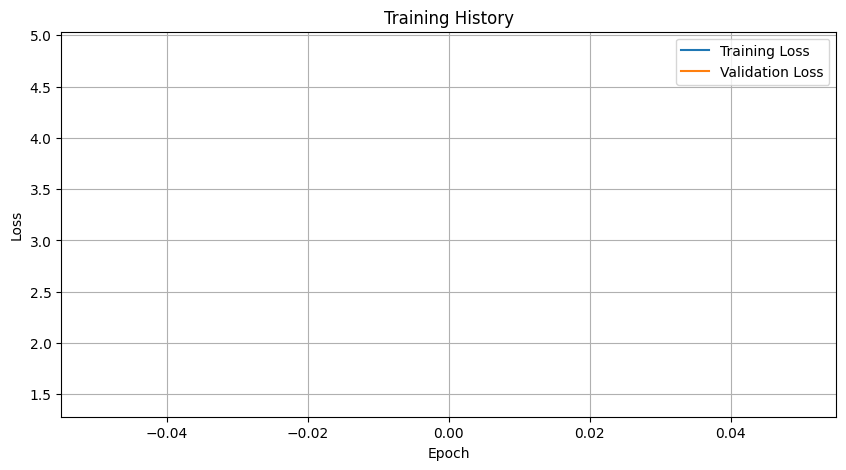

ImageCaptioningModel(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=T

In [8]:
# Model hyperparameters
embed_size = 256
hidden_size = 256  # Changed from 512 to match dimensions
num_layers = 2
learning_rate = 0.001

# Initialize model
model = ImageCaptioningModel(
    embed_size=embed_size,
    hidden_size=hidden_size,
    vocab_size=vocab_size,
    num_layers=num_layers
).to(device)

# Load trained model
checkpoint = torch.load(MODEL_PATH, map_location=device)

epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_losses_history = checkpoint['train_losses']  # List of all training losses
val_losses_history = checkpoint['val_losses']      # List of all validation losses

print(f"Model was trained for {epoch + 1} epochs")
print(f"Final training loss: {train_loss:.4f}")
print(f"Final validation loss: {val_loss:.4f}")
print(f"Training history: {train_losses_history}")
print(f"Validation history: {val_losses_history}")

# You can even plot the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses_history, label='Training Loss')
plt.plot(val_losses_history, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# # If you want to resume training, you can restore the optimizer state:
# optimizer_state = checkpoint['optimizer_state_dict']
# optimizer = torch.optim.Adam(model.parameters())  # Create new optimizer
# optimizer.load_state_dict(optimizer_state)        # Load saved state
# When loading the model, make sure to load the scheduler state if continuing training:
# scheduler_state = checkpoint['scheduler_state_dict']
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
# scheduler.load_state_dict(scheduler_state)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

In [9]:
# Cell 6: Function to visualize predictions
def denormalize_image(image):
    """
    Denormalize image from [-1, 1] range to [0, 1] range
    Args:
        image: tensor of shape (C, H, W)
    Returns:
        denormalized image tensor of shape (C, H, W)
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image.device)
    
    img = image * std + mean  # denormalize
    img = torch.clamp(img, 0, 1)  # clamp to [0, 1]
    return img

def visualize_sample(image, actual_caption, predicted_caption, img_id=None):
    """
    Visualize a single image with its actual and predicted captions
    Args:
        image: tensor of shape (C, H, W)
        actual_caption: string
        predicted_caption: string
        img_id: image ID from COCO dataset (optional)
    """
    plt.figure(figsize=(12, 5))
    
    # Denormalize the image
    img_denorm = denormalize_image(image)
    
    # Convert to numpy and adjust dimensions for plotting
    img_np = img_denorm.cpu().permute(1, 2, 0).numpy()
    
    plt.imshow(img_np)
    
    # Create title with image ID if available
    title = f'Image ID: {img_id}\n' if img_id is not None else ''
    title += f'Actual: {actual_caption}\nPredicted: {predicted_caption}'
    
    plt.title(title, fontsize=12, pad=10)
    plt.axis('off')
    plt.show()

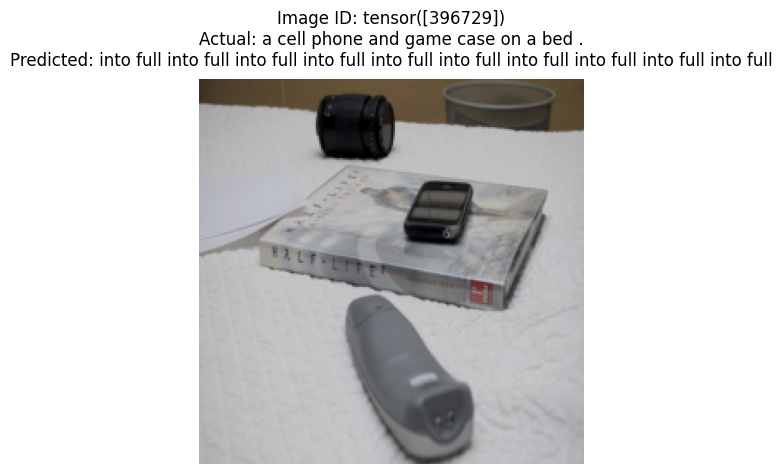

tensor([396729])


In [10]:
# Cell 7: Test the model on some samples
# For single image
image, caption, img_id = next(iter(val_loader))
image = image[0].to(device)

# Get actual caption
actual_caption = ' '.join([val_dataset.idx2word[str(idx.item())] for idx in caption[0]
                          if val_dataset.idx2word[str(idx.item())] not in ['<pad>', '<start>', '<end>']])

# Generate predicted caption
predicted_caption = model.generate_caption(
    image, 
    val_dataset.word2idx, 
    val_dataset.idx2word
)

# Display the results with image ID
visualize_sample(image, actual_caption, predicted_caption, img_id)
print(img_id)

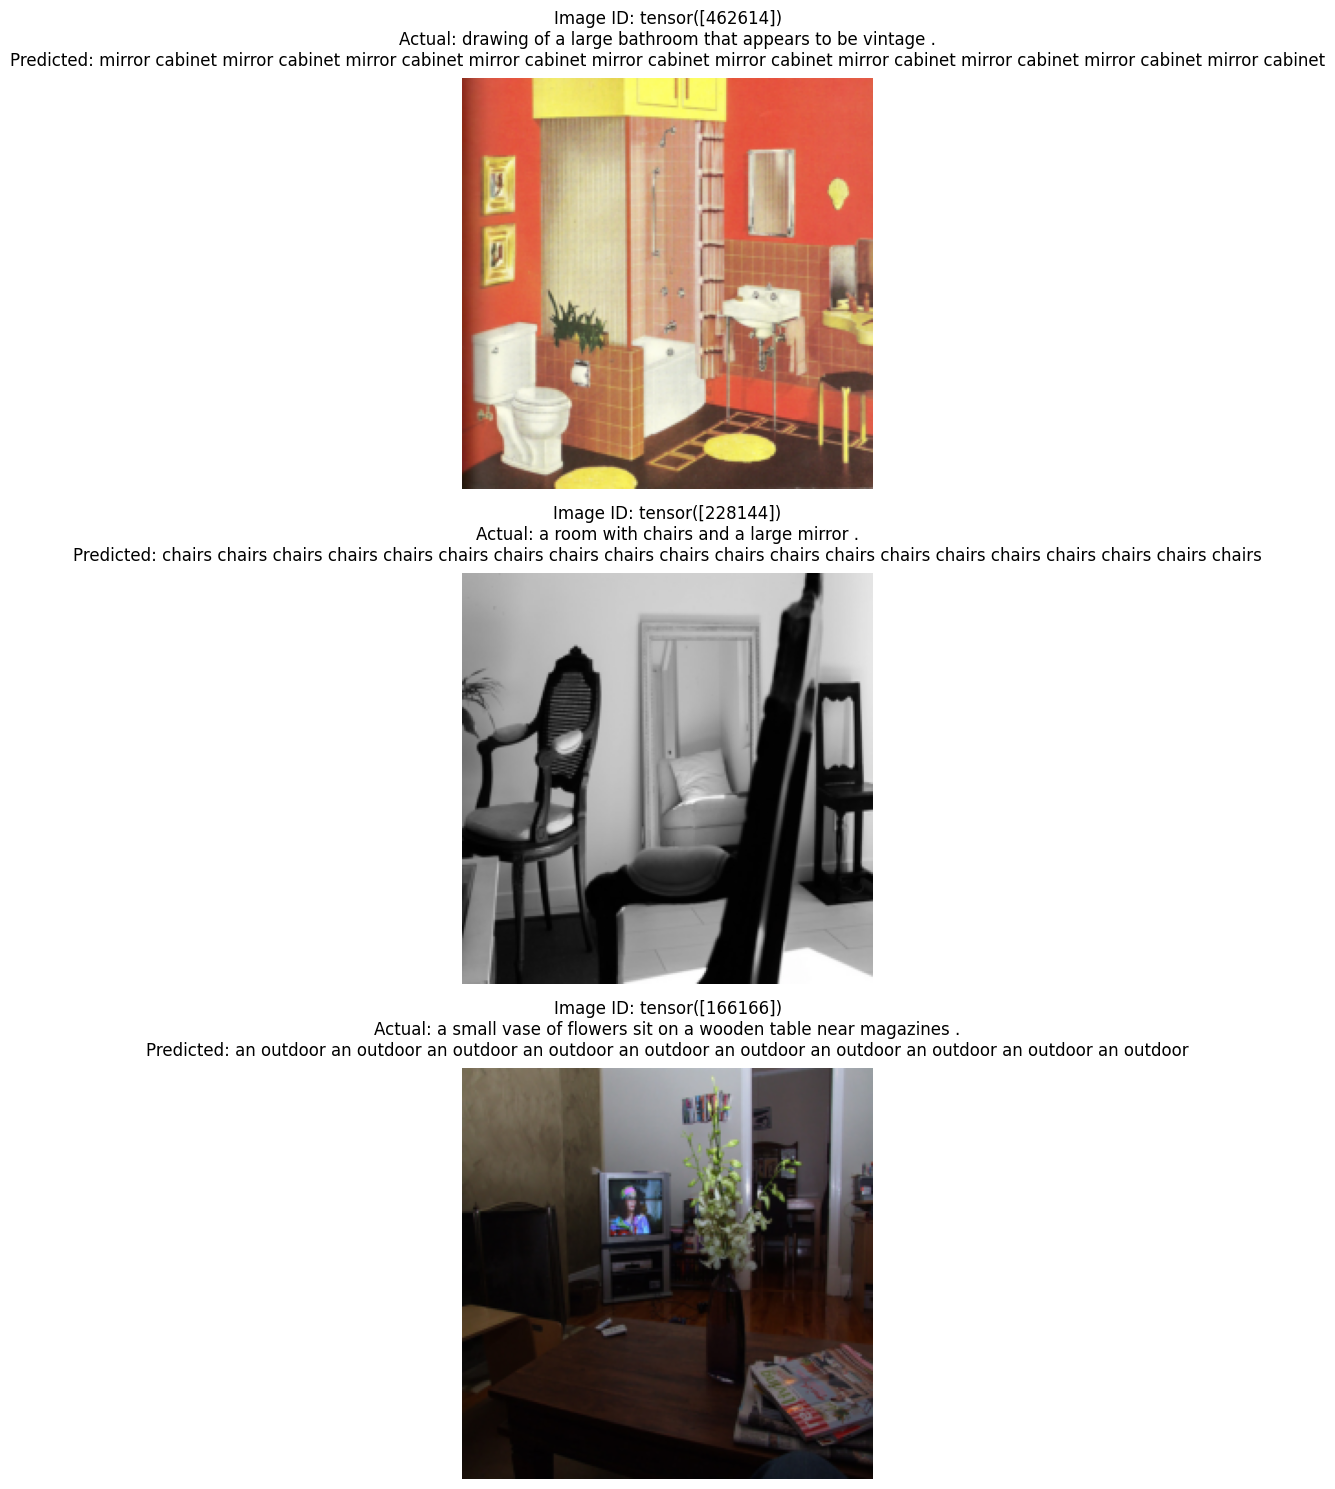

In [11]:
# Cell 8: Visualize multiple samples
def visualize_multiple_samples(model, dataloader, dataset, num_samples=3):
    """
    Visualize multiple samples with their actual and predicted captions
    """
    model.eval()
    plt.figure(figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        image, caption, img_id = next(iter(dataloader))
        image = image[0].to(device)
        
        # Get actual caption
        actual_caption = ' '.join([dataset.idx2word[str(idx.item())] for idx in caption[0]
                                 if dataset.idx2word[str(idx.item())] not in ['<pad>', '<start>', '<end>']])
        
        # Generate predicted caption
        predicted_caption = model.generate_caption(
            image, 
            dataset.word2idx, 
            dataset.idx2word
        )
        
        # Display image and captions
        plt.subplot(num_samples, 1, i+1)
        img_denorm = denormalize_image(image)
        plt.imshow(img_denorm.cpu().permute(1, 2, 0).numpy())
        
        # Add title with image ID
        title = f'Image ID: {img_id}\nActual: {actual_caption}\nPredicted: {predicted_caption}'
        plt.title(title, fontsize=12, pad=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test multiple samples
visualize_multiple_samples(model, val_loader, val_dataset, num_samples=3)

In [ ]:
def evaluate_metrics(model, data_loader, dataset, max_samples=None):
    """
    Evaluate model using BLEU, METEOR, and CIDEr metrics
    
    Args:
        model: trained model
        data_loader: DataLoader instance
        dataset: Dataset instance
        max_samples: Maximum number of samples to evaluate (optional, for testing)
    
    Returns:
        Dictionary containing the evaluation scores
    """
    model.eval()
    
    # Initialize scorers
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(), "METEOR"),
        (Cider(), "CIDEr")
    ]
    
    # Dictionaries to store references and hypotheses
    refs = {}
    hypos = {}
    
    # Collect predictions
    print("Generating predictions...")
    with torch.no_grad():
        for i, (images, captions, _) in enumerate(tqdm.tqdm(data_loader)):
            if max_samples and i >= max_samples:
                break
                
            images = images.to(device)
            
            # Generate prediction
            predicted_caption = model.generate_caption(
                images[0],  # Take first image as we're processing one at a time
                dataset.word2idx,
                dataset.idx2word
            )
            
            # Get reference caption
            ref_caption = ' '.join([dataset.idx2word[str(idx.item())] 
                                  for idx in captions[0]
                                  if dataset.idx2word[str(idx.item())] 
                                  not in ['<pad>', '<start>', '<end>']])
            
            # Store references and hypotheses
            image_id = str(i)
            refs[image_id] = [ref_caption]
            hypos[image_id] = [predicted_caption]
    
    # Compute scores
    print("\nComputing scores...")
    scores = {}
    
    for scorer, method in scorers:
        print(f'Computing {method} score...')
        score, scores_per_caption = scorer.compute_score(refs, hypos)
        
        if isinstance(method, list):
            for sc, m in zip(score, method):
                scores[m] = sc
        else:
            scores[method] = score
            
    return scores

def print_scores(scores):
    """Pretty print the evaluation scores"""
    print("\nEvaluation Scores:")
    print("=" * 50)
    for metric, score in scores.items():
        print(f"{metric:<10}: {score:.4f}")
    print("=" * 50)

# Example usage:
# Evaluate on validation set
print("Evaluating model on validation set...")
val_scores = evaluate_metrics(model, val_loader, val_dataset)
print_scores(val_scores)

# To evaluate on specific number of samples (e.g., for testing):
# test_scores = evaluate_metrics(model, val_loader, val_dataset, max_samples=100)
# print_scores(test_scores)

# # You can also save the scores to a file
# with open('evaluation_scores.json', 'w') as f:
#     json.dump(val_scores, f, indent=4)
# print("\nScores saved to evaluation_scores.json")

In [ ]:
with open(os.path.join(CHECKPOINT_PATH, MODEL_NAME+'_evaluation_scores.json'), 'w') as f:
    json.dump(val_scores, f, indent=4)
print("\nScores saved to "+ MODEL_NAME + "_evaluation_scores.json")


Scores saved to checkpoint_epoch_8.pt_evaluation_scores.json
